# CNN Based Chest X-Ray Pneumonia Detection

## Module installation and Data Download

**Action required!**  
Replace api token below with your kaggle api token

In [ ]:
api_token = {"username":"XXX","key":"XXXX"}

In [ ]:
!pip install kaggle
!pip install wandb
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json

import os
import random
import shutil
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
from collections import Counter

import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import wandb
from torchsummary import summary
import datetime

mkdir: cannot create directory ‘/root/.config/kaggle’: File exists
Mounted at /content/drive


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Setting the seed for reproducible results (https://pytorch.org/docs/stable/notes/randomness.html)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

if torch.cuda.is_available():
  torch.cuda.manual_seed(0)
  torch.cuda.manual_seed_all(0)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


## Load and Re-split the Raw Data

In [ ]:
# Hyperparameters
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

In [ ]:
# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the dataset
dataset = "paultimothymooney/chest-xray-pneumonia"

# Specify the download path
download_path = "chest_xray_dataset"

# Check if the dataset is already downloaded
if os.path.exists(os.path.join(download_path, "chest_xray")):
    print(f"Dataset already exists at {download_path}. Skipping download.")
else:
    # Create the download directory if it doesn't exist
    os.makedirs(download_path, exist_ok=True)

    # Download the dataset
    print(f"Downloading {dataset} to {download_path}")
    api.dataset_download_files(dataset, path=download_path, unzip=True)
    print("Download complete!")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
Download complete!


In [ ]:
# Re-split data
dataset_path = os.path.join(download_path, "chest_xray")
new_dataset_path = "chest_xray_dataset_new_split"

if not os.path.exists(new_dataset_path):
    # Create new directory structure
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = os.path.join(dataset_path, split, cls)
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        # Sort files to ensure consistent order before shuffling
        all_files.sort()

        # Create a new Random object with the seed
        rng = random.Random(42)

        # Use the shuffle method of the Random object
        rng.shuffle(all_files)

        total_files = len(all_files)
        train_end = int(total_files * TRAIN_SPLIT)
        val_end = int(total_files * (TRAIN_SPLIT + VAL_SPLIT))

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        for split, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for file, source_folder in file_list:
                source = os.path.join(source_folder, file)
                dest = os.path.join(new_dataset_path, split, cls, file)
                shutil.copy(source, dest)

    print(f"Data re-split complete. New dataset location: {new_dataset_path}")
else:
    print(f"Re-split dataset already exists at {new_dataset_path}")

Data re-split complete. New dataset location: chest_xray_dataset_new_split


## Data Analysis



In [ ]:
# Collect dataset statistics

splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

stats = {split: {cls: 0 for cls in ['NORMAL', 'PNEUMONIA']} for split in ['train', 'val', 'test']}
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        stats[split][cls] = len(os.listdir(path))

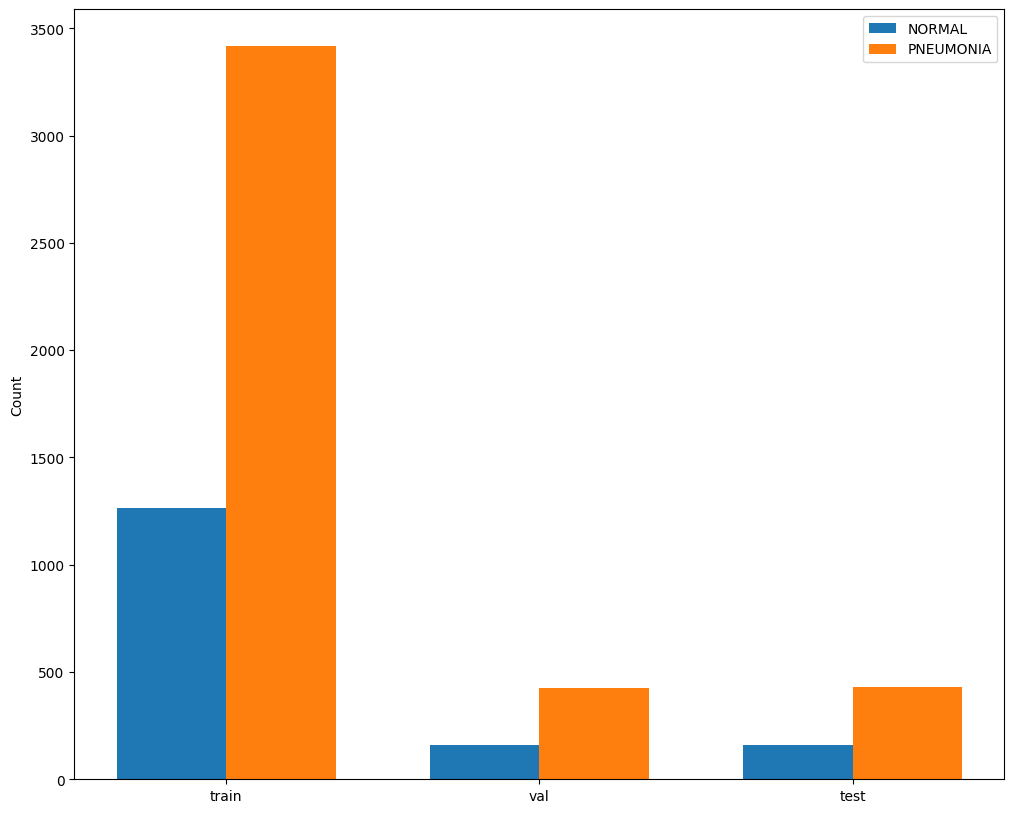

In [ ]:
# Visualise Class Distribution

sets = list(stats.keys())
normal = [stats[dataset]['NORMAL'] for dataset in sets]
pneumonia = [stats[dataset]['PNEUMONIA'] for dataset in sets]

bar_width = 0.35
pos1 = np.arange(len(sets))
pos2 = [x + bar_width for x in pos1]

f = plt.figure(figsize=(12,10))
plt.bar(pos1, normal, bar_width, label='NORMAL')
plt.bar(pos2, pneumonia, bar_width, label='PNEUMONIA')
plt.xticks([x + bar_width/2 for x in range(len(sets))] , sets)
plt.legend()
plt.ylabel('Count')
plt.show()

['person1343_bacteria_3419.jpeg', 'person1484_bacteria_3878.jpeg', 'person1531_bacteria_4003.jpeg', 'person413_virus_844.jpeg', 'person1218_bacteria_3171.jpeg', 'person1271_virus_2164.jpeg', 'person28_bacteria_139.jpeg', 'person543_bacteria_2281.jpeg', 'person574_bacteria_2370.jpeg']


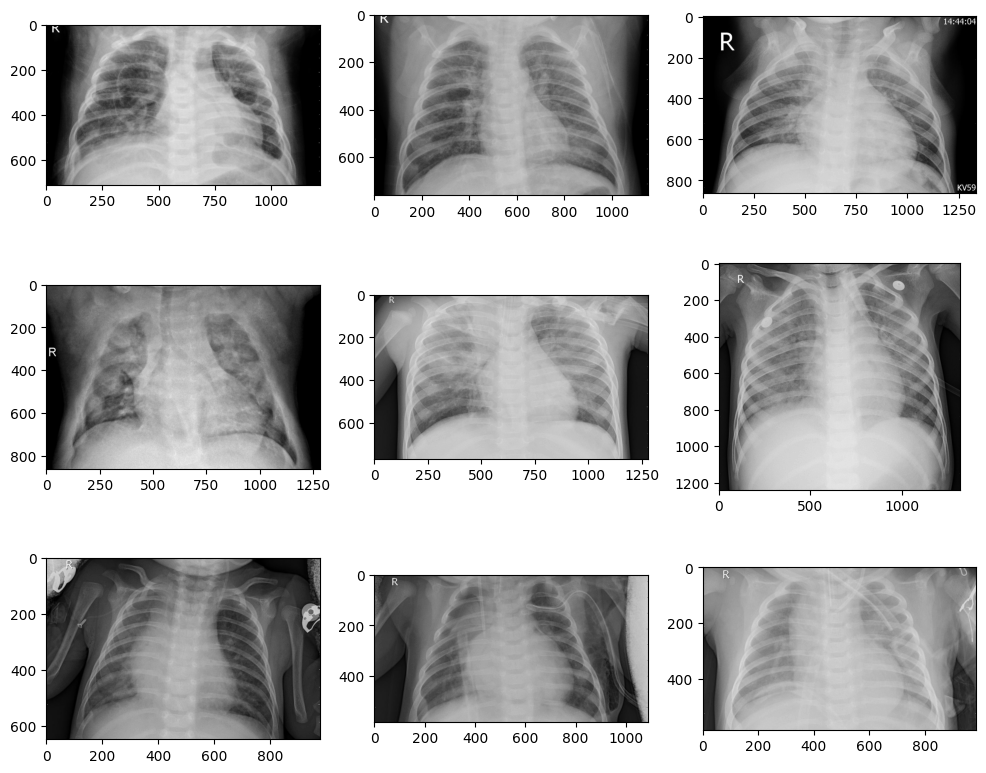

In [ ]:
# Visualising Training Images

path = os.path.join(new_dataset_path,'train','PNEUMONIA')
items = os.listdir(path)
idx = np.random.randint(0,len(items),9)
print(list(items[i] for i in idx))

f = plt.figure(figsize= (12,10))
for i,id in enumerate(idx):
  img_path = os.path.join(path, items[id])
  with Image.open(img_path) as im:
    a = np.asarray(im)
    f.add_subplot(3,3,i+1)
    plt.imshow(a,cmap='gray')
plt.show()


In [ ]:
dataset_path = "chest_xray_dataset_new_split"
batch_size = 32

In [ ]:
train_set = ImageFolder(os.path.join(dataset_path, 'train'), transform= transforms.ToTensor())

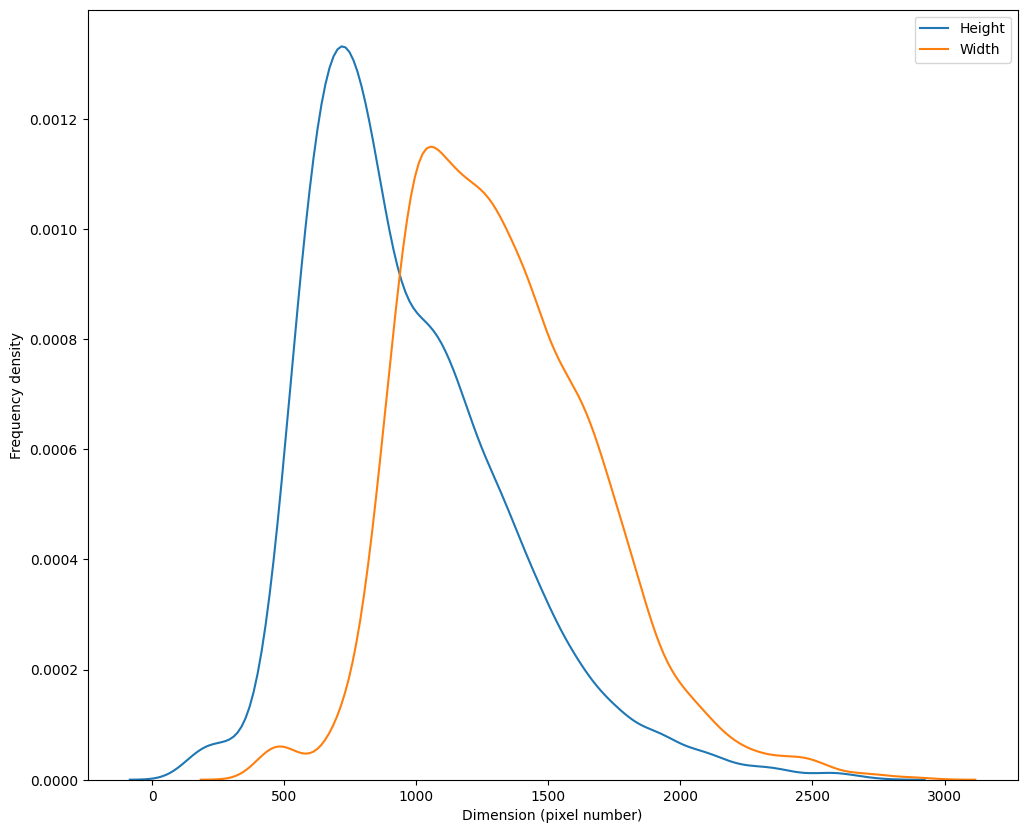

In [ ]:
# Visualise the dimensions distribution
f = plt.figure(figsize= (12,10))

sns.kdeplot(x= [values[0].shape[1] for values in train_set], label = 'Height')
sns.kdeplot(x= [values[0].shape[2] for values in train_set], label = 'Width')
plt.xlabel('Dimension (pixel number)')
plt.ylabel('Frequency density')
plt.legend()

In [ ]:
# Check if images are RGB or Greyscale

channel_counts = Counter(train_set[i][0].shape[0] for i in range(len(train_set)))

for channel, count in channel_counts.items():
  print(f"There are {count} images with {channel} channels.")



## Data Pre-processing

In [ ]:
# Define data transforms

transformations_train = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomAffine(degrees=10, shear= (-10,10,-10,10)), #Train Data Augmentation
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])

transformations = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])


In [ ]:
# Create datasets
train_set = ImageFolder(os.path.join(dataset_path, 'train'), transform=transformations_train)
val_set = ImageFolder(os.path.join(dataset_path, 'val'), transform=transformations)
test_set = ImageFolder(os.path.join(dataset_path, 'test'), transform=transformations)

# Handling Imbalance
class_weights = []
for label in train_set.class_to_idx.values():
  class_weights.append(1.0 / train_set.targets.count(label))

sample_weights = [class_weights[label] for _, label in train_set]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create data loaders
train_dataloader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, worker_init_fn=seed_worker)
test_dataloader = DataLoader(test_set, batch_size=batch_size, worker_init_fn=seed_worker)
val_dataloader = DataLoader(val_set, batch_size=batch_size, worker_init_fn=seed_worker)

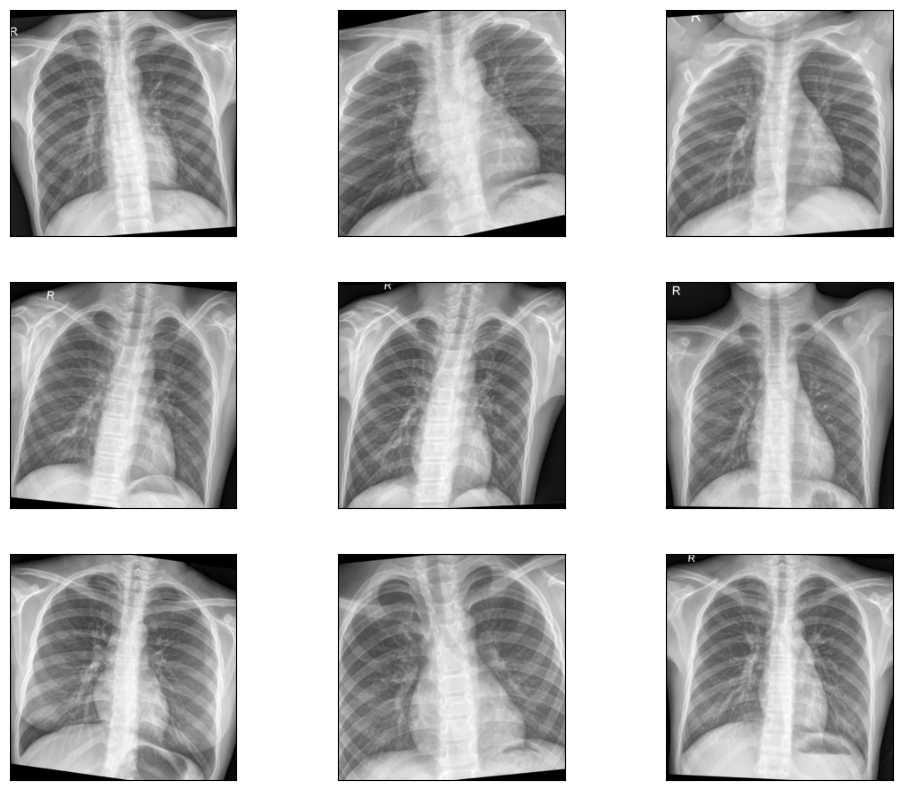

In [ ]:
# Visualise Train Data

f = plt.figure(figsize=(12,10))
for i in range(1,10):
  img = train_set[i][0]
  np_img = img.numpy().squeeze()
  np_img = np_img*0.5 + 0.5
  f.add_subplot(3,3,i, xticks=[], yticks=[])
  plt.imshow(np_img, cmap='gray')

plt.show()

## Defining the CNN


In [ ]:
def calculate_class_accuracy(outputs, labels):

  # Apply a 0.5 threshold to convert output to label
  predicted_labels = (outputs.cpu() >= 0.5).int()

  # Initialise class accuracy list
  class_accuracy = []

  # Iterate over the two labels
  for label in [0,1]:

    # Identify which samples belong to which class
    indices = (labels.cpu() == label).nonzero().squeeze()

    # Count how many predicitons match the label
    if indices.dim() > 0 and len(indices) > 0:
      correct = (predicted_labels[indices] == label).sum().item()
      class_accuracy.append(100 * correct/len(indices))
    else:
      class_accuracy.append(50)

  return class_accuracy

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device='cuda'):

  model.train()

  train_epoch_losses = 0
  train_epoch_accuracies = 0

  train_epoch_preds = []
  train_epoch_labels = []

  range_gen = tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc="Training Epoch"
      )

  for i, (X, y) in range_gen:

    X = X.to(device)
    y = y.to(device).float()

    # Set gradients to zero
    optimizer.zero_grad()

    output = model(X)
    correct = ((output >= 0.5).int() == y).sum().item()
    accuracy = 100 * correct/y.size(0)
    train_epoch_accuracies += accuracy

    train_loss = criterion(output, y)
    train_epoch_losses += train_loss.item()

    grad = train_loss.backward()
    optimizer.step()

    train_epoch_preds.append(output)
    train_epoch_labels.append(y)

  train_epoch_losses = train_epoch_losses / len(train_loader)
  train_epoch_accuracies = train_epoch_accuracies / len(train_loader)
  train_epoch_class_accuracies = calculate_class_accuracy(torch.cat(train_epoch_preds), torch.cat(train_epoch_labels))

  return train_epoch_losses, train_epoch_accuracies, train_epoch_class_accuracies

In [ ]:
def eval_model(model, val_loader, criterion, optimizer, device='cuda'):

  model.eval()

  val_epoch_losses = 0
  val_epoch_accuracies = 0

  val_epoch_preds = []
  val_epoch_labels = []

  with torch.no_grad():

    range_gen = tqdm(
        enumerate(val_loader))

    for i, (X,y) in range_gen:

      X = X.to(device)
      y = y.to(device).float()

      output = model(X)
      correct = ((output >= 0.5).int() == y).sum().item()

      val_epoch_losses += criterion(output, y).item()
      accuracy = 100 * correct/y.size(0)
      val_epoch_accuracies += accuracy

      val_epoch_preds.append(output)
      val_epoch_labels.append(y)

    val_epoch_losses = val_epoch_losses / len(val_loader)
    val_epoch_accuracies = val_epoch_accuracies / len(val_loader)
    val_epoch_class_accuracies = calculate_class_accuracy(torch.cat(val_epoch_preds), torch.cat(val_epoch_labels))


  return val_epoch_losses, val_epoch_accuracies, val_epoch_class_accuracies

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda', use_wandb=False):

  model.to(device)

  train_losses = []
  train_accuracies = []
  train_class_accuracies = []

  val_losses = []
  val_accuracies = []
  val_class_accuracies = []

  best_val_loss = float('inf')

  for epoch in range(num_epochs):

    # Train
    train_loss, train_acc, train_class_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_class_accuracies.append(train_class_acc)

    # Eval
    val_loss, val_acc, val_class_acc = eval_model(model, val_loader, criterion, optimizer, device)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_class_accuracies.append(val_class_acc)

    if use_wandb:

      wandb.log({"train_loss": train_loss,
                 "train_normal_accuracy": train_class_acc[0],
                 "train_pneumonia_accuracy": train_class_acc[1],
                 "train_accuracy": train_acc,
                 "val_loss": val_loss,
                 "val_accuracy": val_acc,
                 "val_normal_accuracy": val_class_acc[0],
                 "val_pneumonia_accuracy": val_class_acc[1]
                 })

      # Save the best model checkpoint
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        chkp_pth = os.path.join(wandb.run.dir, f"mdl_chkpnt_epoch_{epoch}.pt")
        torch.save(
            {'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, chkp_pth)
        # Log the path of the best model checkpoint
        wandb.log({"best_model_path": chkp_pth})

  return train_losses, train_accuracies, train_class_accuracies, val_losses, val_accuracies,  val_class_accuracies


In [ ]:
def plot_training_curves(train_losses, train_accuracies, train_class_accuracies, val_losses, val_accuracies,  val_class_accuracies):

  epochs = len(train_losses)

  # Losses
  plt.figure(figsize=(10, 6))
  train_loss_plot = plt.plot(range(1, epochs + 1), train_losses, label = 'Train Losses')
  val_loss_plot = plt.plot(range(1, epochs + 1), val_losses, label = 'Validation Losses')
  plt.xlabel('Epochs')
  plt.ylabel('BCE Loss')
  plt.legend()
  plt.show()

  # Accuracies
  plt.figure(figsize=(10, 6))
  train_acc_plot = plt.plot(range(1, epochs + 1), train_accuracies, label = 'Train Accuracies')
  val_acc_plot = plt.plot(range(1, epochs + 1), val_accuracies, label = 'Validation Accuracies')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  # Class Accuracies
  plt.figure(figsize=(10, 6))

  train_class_0_acc = [epoch[0] for epoch in train_class_accuracies]
  train_class_1_acc = [epoch[1] for epoch in train_class_accuracies]
  val_class_0_acc = [epoch[0] for epoch in val_class_accuracies]
  val_class_1_acc = [epoch[1] for epoch in val_class_accuracies]

  train_class_0_acc_plot = plt.plot(range(1, epochs + 1), train_class_0_acc, label = 'Train "NORMAL" Accuracies')
  train_class_1_acc_plot = plt.plot(range(1, epochs + 1), train_class_1_acc, label = 'Train "PNEUMONIA" Accuracies')
  val_class_0_acc_plot = plt.plot(range(1, epochs + 1), val_class_0_acc, label = 'Validation "NORMAL "Accuracies')
  val_class_1_acc_plot = plt.plot(range(1, epochs + 1), val_class_1_acc, label = 'Validation "PNEUMONIA" Accuracies')

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()


In [ ]:
class CNN(nn.Module):


  def __init__(self, img_input_size=256, filter_sizes=(128,256), batch_norm=False, dropout=False):
      super().__init__()

      self.layers = nn.ModuleList([])

      for i in range(len(filter_sizes)):
          if i == 0:
            self.layers.append(nn.Conv2d(1, filter_sizes[i], kernel_size=(3,3), stride=1, padding=1))
            self.layers.append(nn.ReLU())
            if batch_norm:
              self.layers.append(nn.BatchNorm2d(filter_sizes[i]))
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=2))
          else:
            self.layers.append(nn.Conv2d(filter_sizes[i-1], filter_sizes[i], kernel_size=(3,3), stride=1, padding=1))
            self.layers.append(nn.ReLU())
            if batch_norm:
              self.layers.append(nn.BatchNorm2d(filter_sizes[i]))
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=2))

      linear_size = (img_input_size * (1/2)**(len(filter_sizes)))**2 * filter_sizes[-1]
      self.layers.append(nn.Flatten())
      self.layers.append(nn.Linear(int(linear_size), 1))
      if dropout:
        self.layers.append(nn.Dropout(0.2))
      self.layers.append(nn.Sigmoid())


  def forward(self,x):

    for layer in self.layers:
      x = layer(x)
    x = x.squeeze()

    return x

## Training the CNN

In [ ]:
num_epochs = 10
lr = 0.0001

use_wandb= True

model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

if use_wandb:

  wandb.login()

  wandb.init(project='PneumoniaClassification', name=f'CNN Model')

  train_losses, train_accuracies, train_class_accuracies, val_losses, val_accuracies,  val_class_accuracies = train_model(
      model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device, use_wandb)

  wandb.finish()

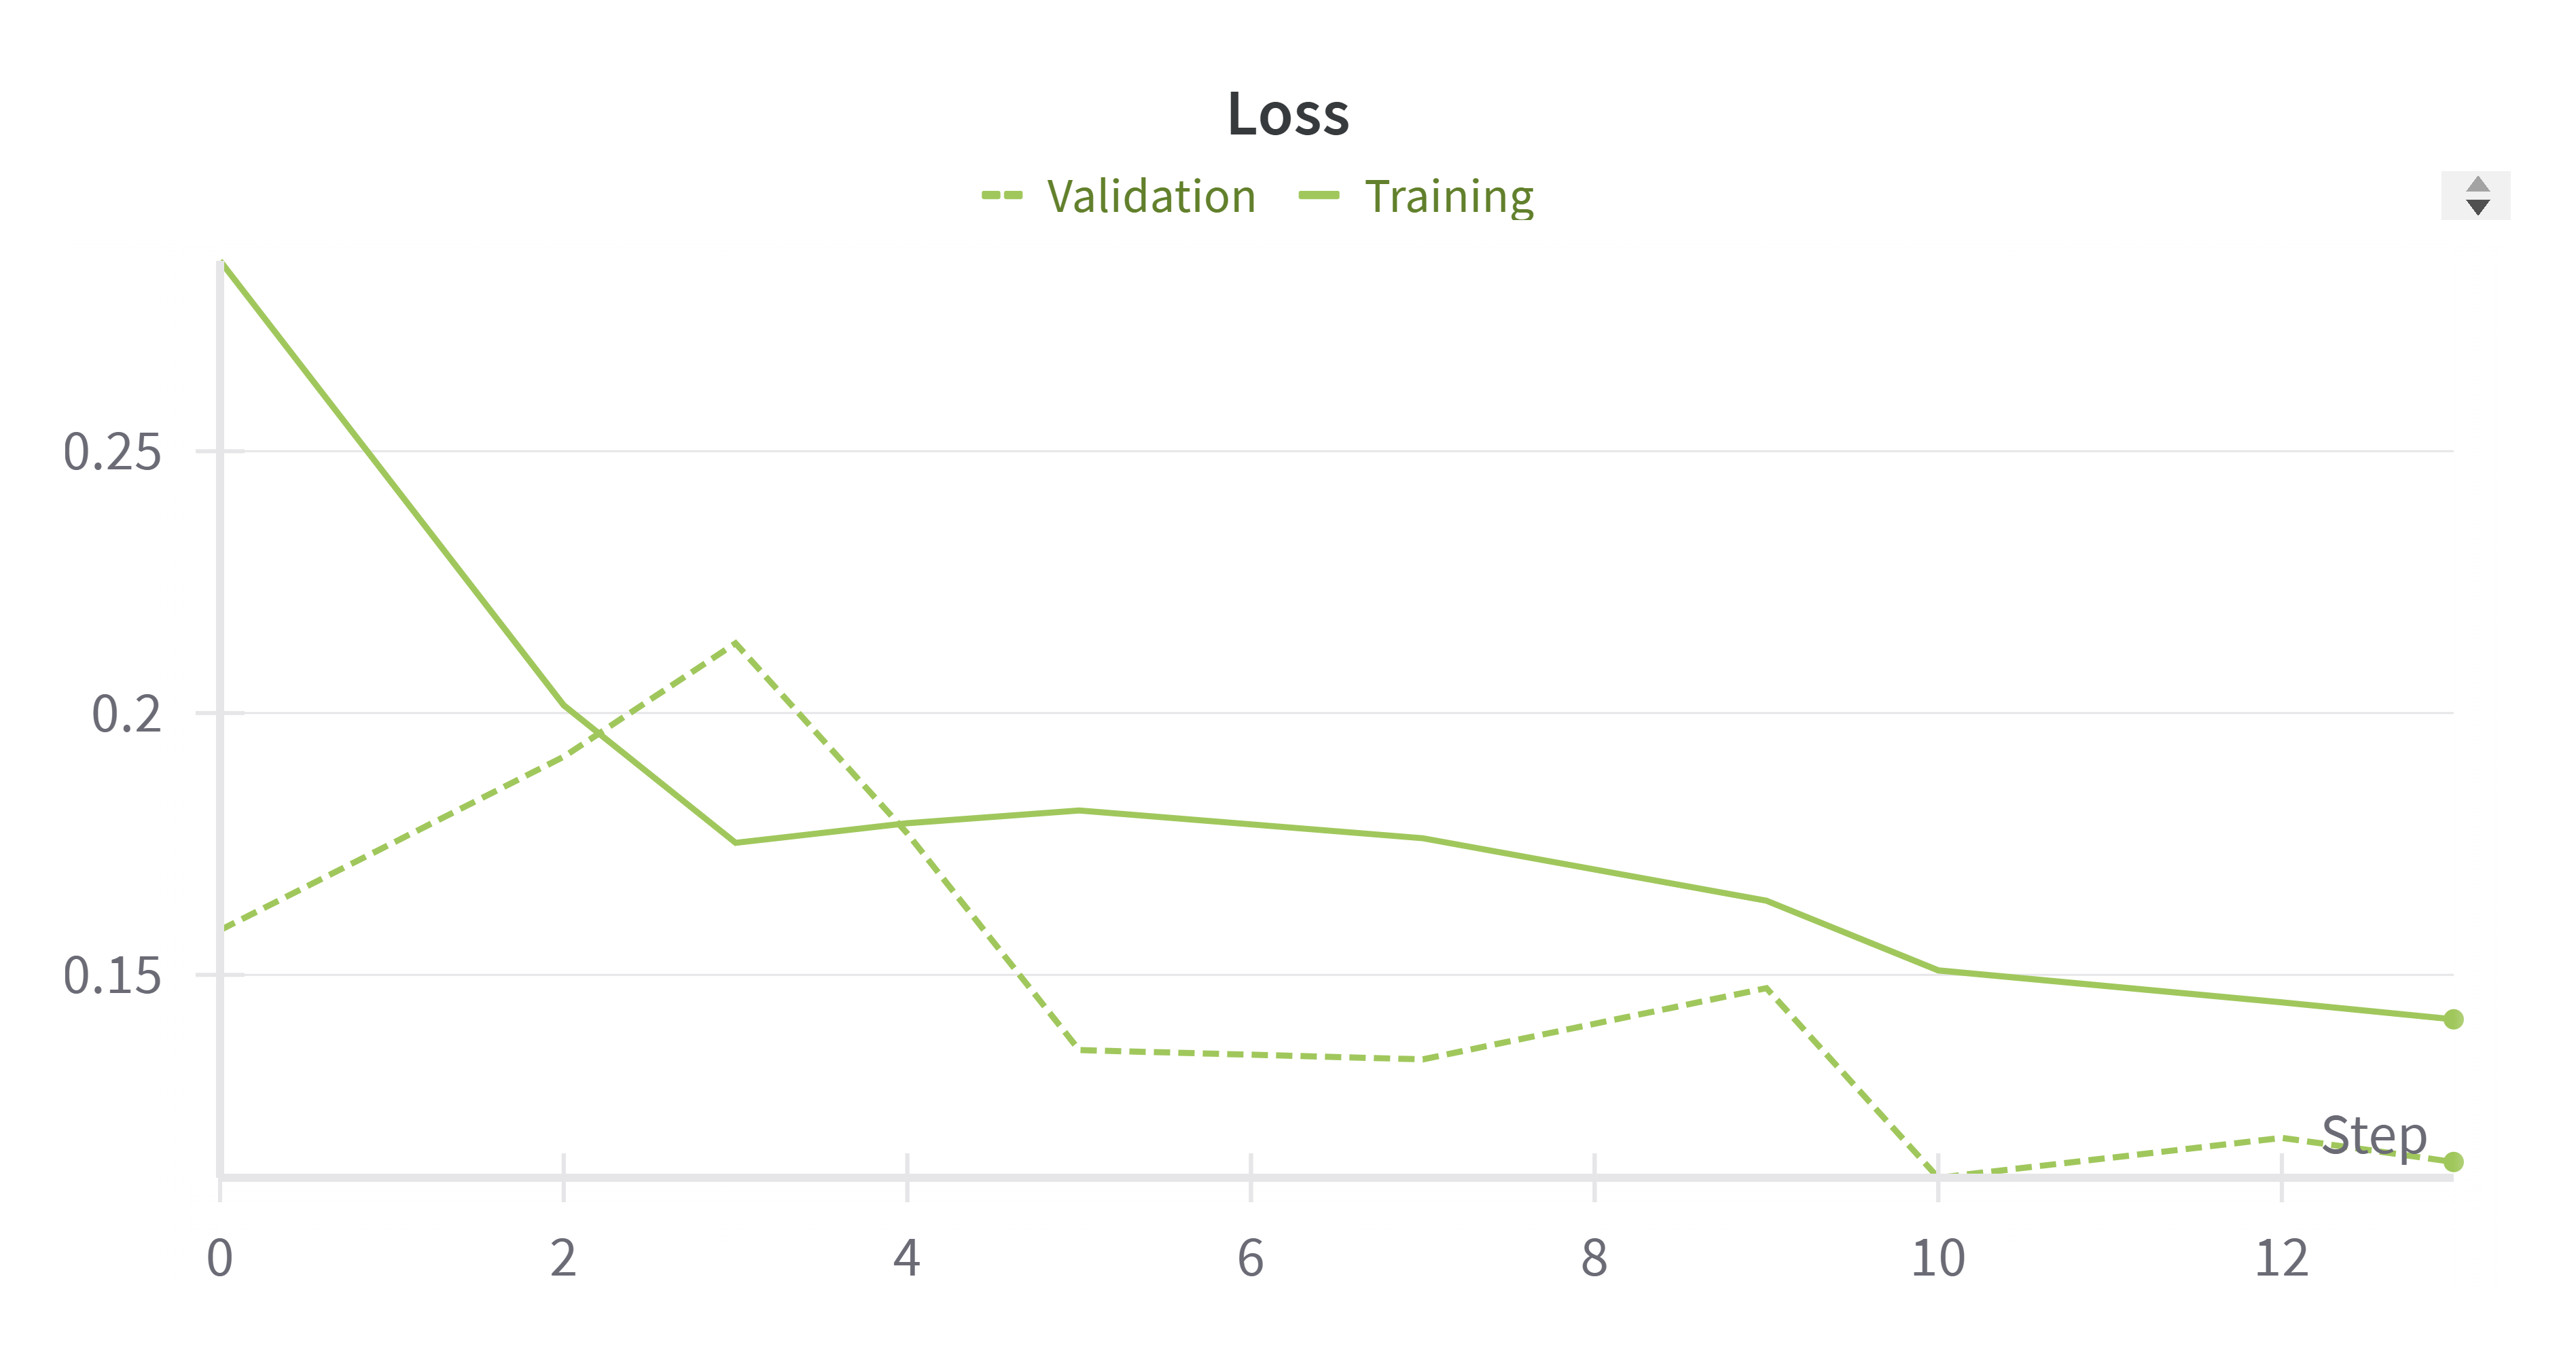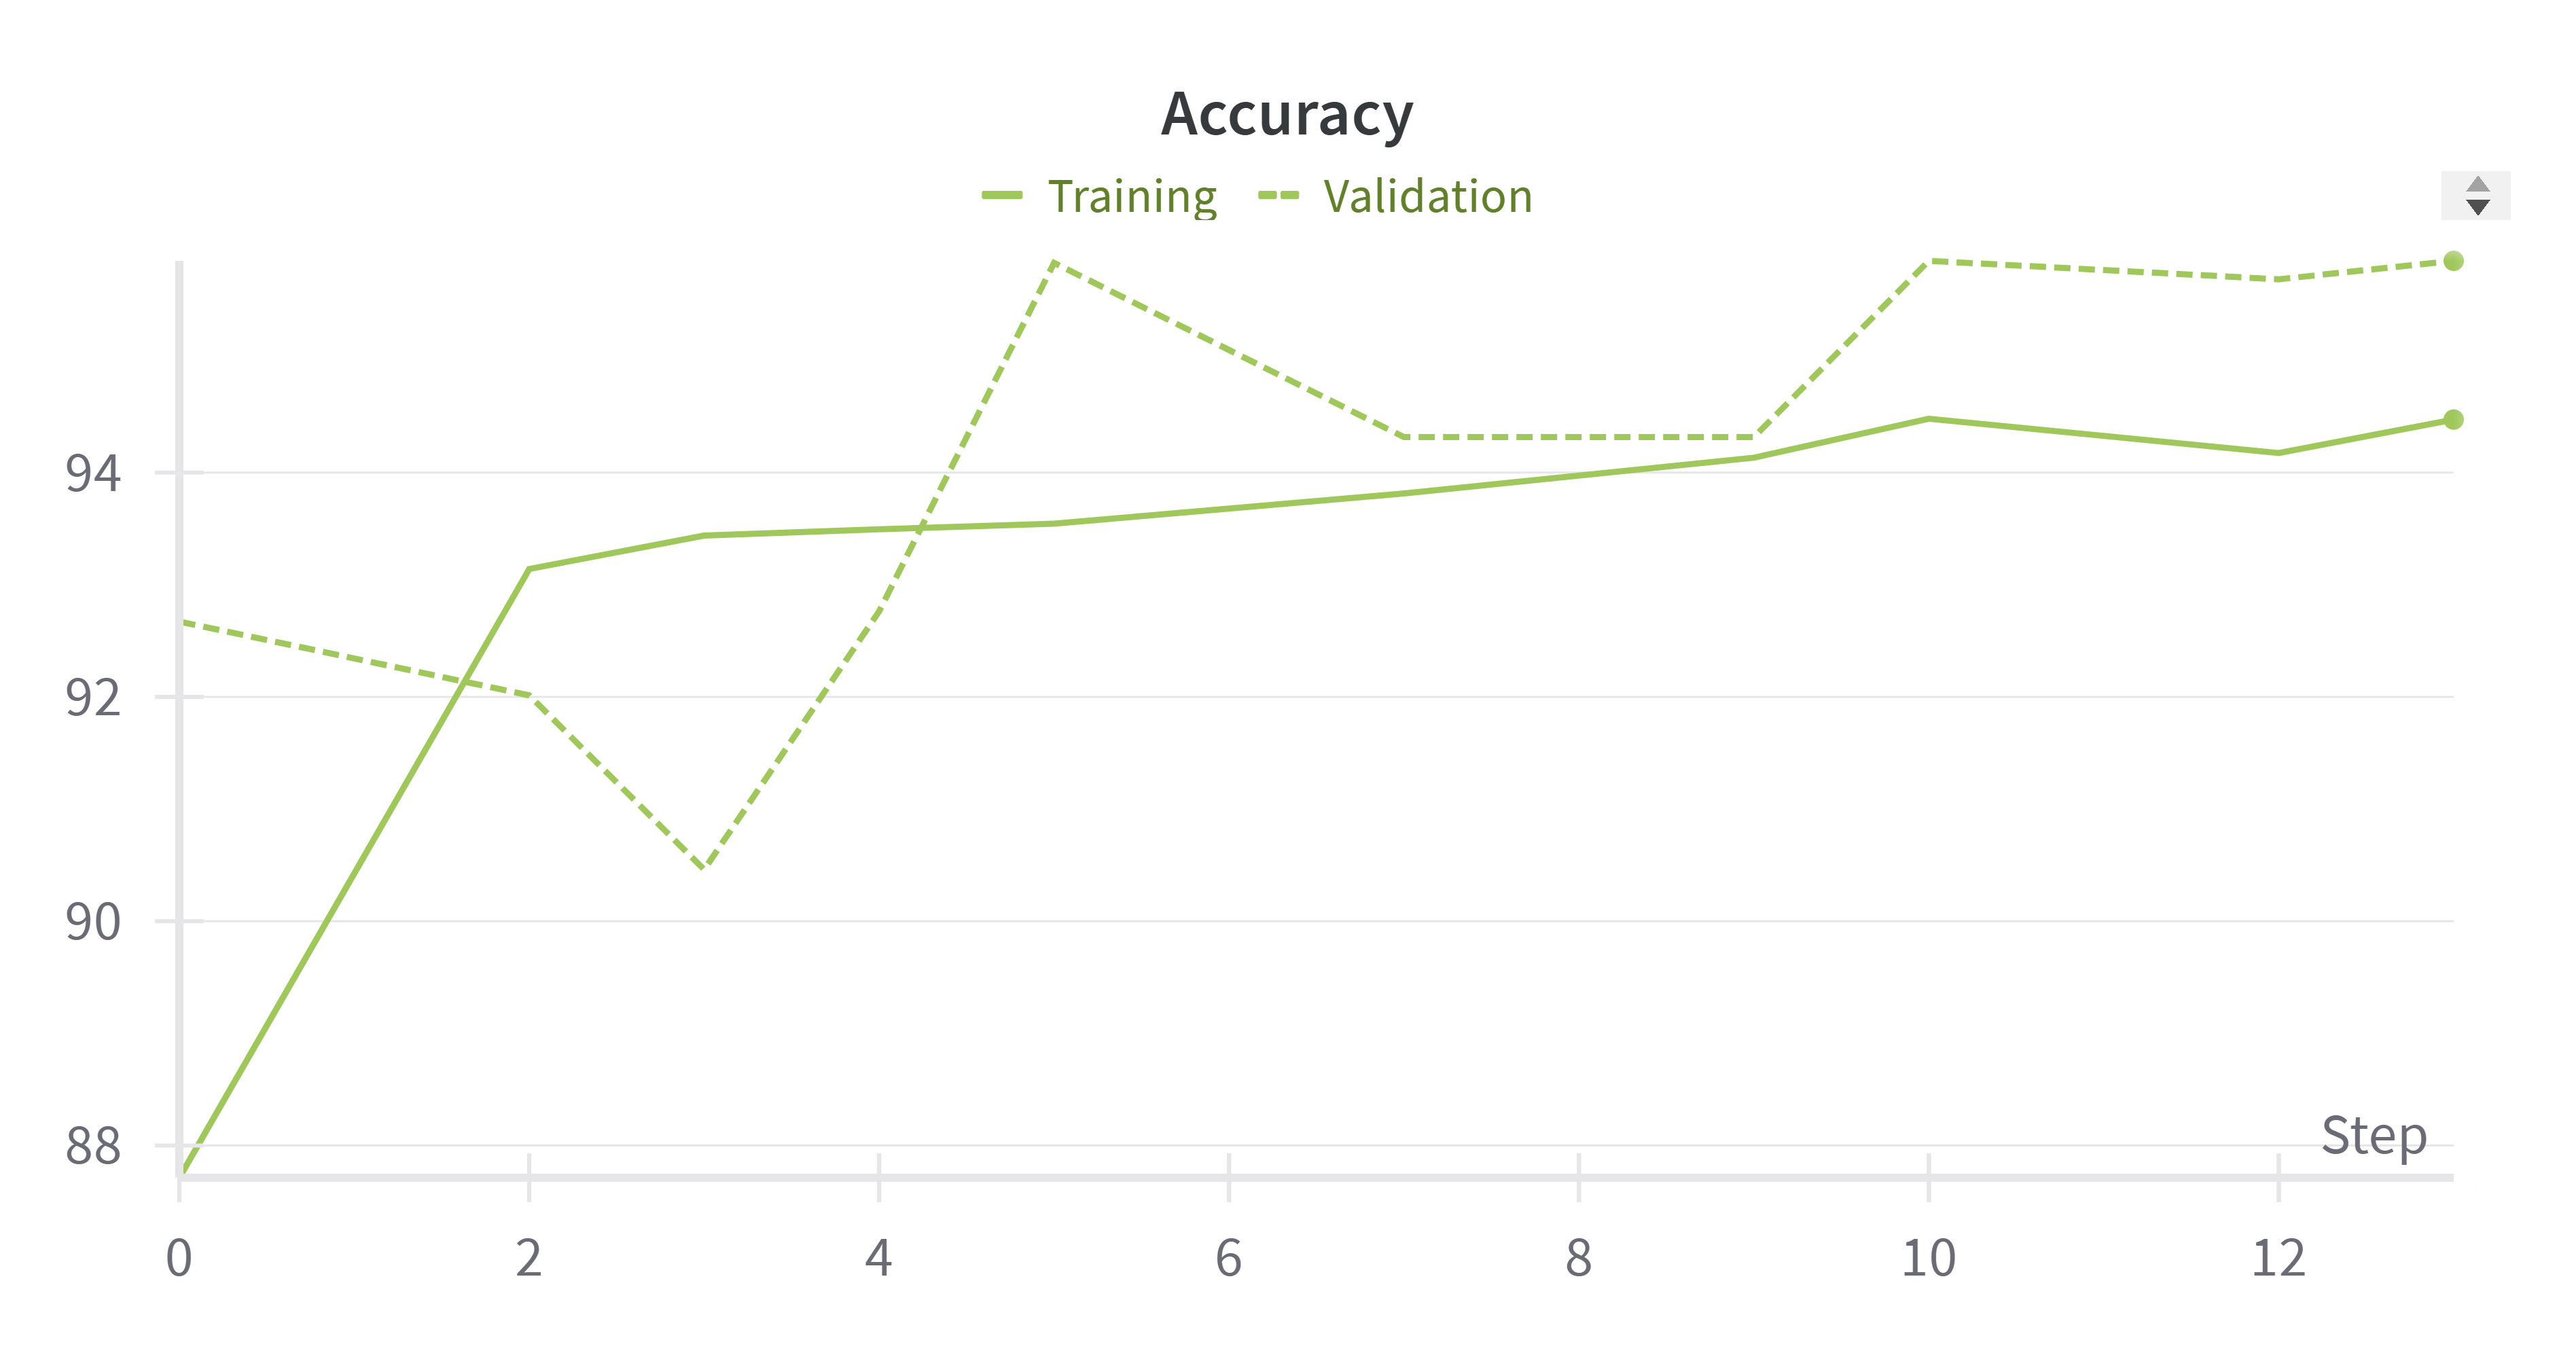

## Evaluate Model

**Action required**  
Replace chkp_pth with your best model path

In [ ]:
# Load the best model

best_model = CNN()
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

chkp_path = '/content/drive/MyDrive/ColabNotebooks/DeepLearning/CW1/optimal_model_lastepoch.pth'
checkpoint = torch.load(chkp_path)
best_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_model.to(device)

_, test_accuracy, test_class_accuracy = eval_model(best_model, test_dataloader, criterion, optimizer, device )

<ipython-input-37-42a3627f6d6c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkp_path)
19it [00:09,  2.04it/s]


The model had an overall accuracy on the test set of  94.57.


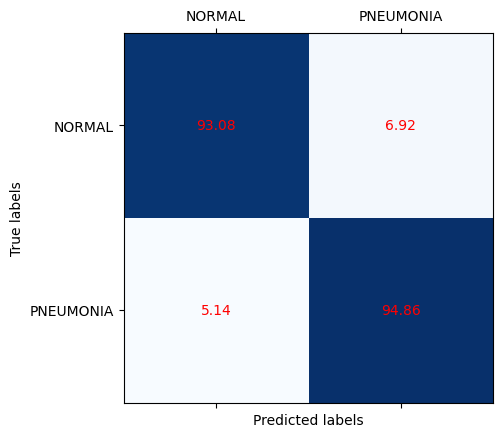

In [ ]:
# Visualise Results

# Accuracy
print(f'The model had an overall accuracy on the test set of {test_accuracy: .2f}.')

#Confusion matrix
TNR = test_class_accuracy[0]
TPR = test_class_accuracy[1]

confusion_matrix = np.array([[TNR, 100 - TNR],
                             [100 - TPR, TPR]])

fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap='Blues')

for (i, j), value in np.ndenumerate(confusion_matrix):
    ax.text(j, i, f'{value:.2f}', ha='center', va='center', color='red')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['NORMAL', 'PNEUMONIA'])
ax.set_yticklabels(['NORMAL', 'PNEUMONIA'])
plt.show()

# Recall, Precision and F1
TotalN = stats['test']['NORMAL']
TotalP = stats['test']['PNEUMONIA']

TP = TPR * TotalP
TN = TNR * TotalN

Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1 = 2 * (Precision * Recall) / (Precision + Recall)

print(f'The model had a precision of {Precision: .2f}.')
print(f'The model had a recall of {Recall: .2f}.')
print(f'The model had an F1 score of {F1: .2f}.')